In [1]:
input_array = [bytes(range(idx, 32 + idx)) for idx in range(10)]

In [10]:
%rm -rf /content/google-colab/
!git clone https://github.com/eshnil2000/google-colab.git
%cd google-colab
import web3
from web3 import Web3
web3 = Web3(Web3.HTTPProvider("loaclhost:8545",request_kwargs={'timeout':60}))
web3.isConnected()

import config as cfg
cfg.DEBUG='TRUE'
import json
with open('contract/Danku_demo_final.json') as json_file:  
    data = json.load(json_file)


In [11]:
web3.eth.defaultAccount=web3.eth.accounts[1]
myContract = web3.eth.contract(abi=data['abi'], bytecode=data['bytecode'])


In [12]:
tx_hash=myContract.constructor().transact()

In [13]:
tx_receipt = web3.eth.waitForTransactionReceipt(tx_hash)

In [14]:
# Create the contract instance with the newly-deployed address
myContractaddress = web3.eth.contract(
    address=tx_receipt.contractAddress,
    abi=data['abi'],
)

In [15]:
from dutils.dataset import DemoDataset
from dutils.neural_network import NeuralNetwork
import dutils.debug as dbg
from secrets import randbelow
from matplotlib import pyplot as plt
import numpy as np

In [16]:
scd = DemoDataset(training_percentage=0.8,partition_size=5)
scd.generate_nonce()
scd.sha_all_data_groups()


/opt/tljh/user/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


(0) Hashed data group: [32383145, -82557135, 1, 33178426, -81182699, 0, 30288896, -84848444, 1, 34010202, -96754984, 1, 42697957, -122769269, 1, 2742906376]

(1) Hashed data group: [31501042, -85113506, 1, 39839405, -74945624, 0, 47271463, -96182441, 1, 33904480, -84862139, 1, 36337083, -102916844, 1, 867575839]

(2) Hashed data group: [41124530, -83144773, 1, 27867945, -80541647, 1, 42309687, -83772991, 0, 40867331, -74578269, 1, 36572762, -86305594, 1, 12425211]

(3) Hashed data group: [37236073, -86270740, 1, 45934055, -96012359, 1, 43111474, -93467873, 1, 41336115, -85500246, 1, 44318900, -70477506, 1, 2732938395]

(4) Hashed data group: [32946307, -80948043, 1, 43667270, -94673433, 1, 32743851, -81628687, 1, 40616536, -81681707, 1, 32400038, -97933708, 1, 131332403]

(5) Hashed data group: [42238161, -96472847, 1, 38214874, -112923106, 1, 35521229, -81418729, 1, 34964812, -80427656, 1, 42788579, -103299462, 1, 809473407]

(6) Hashed data group: [36277602, -100273561, 1, 47785848, 

In [17]:
offer_account = web3.eth.accounts[1]
solver_account = web3.eth.accounts[2]
_hashed_data_groups = []
accuracy_criteria = 5000 # 50.00%
#total_gas_used = 0
timeout = 180
w_scale = 1000 # Scale up weights by 1000x
b_scale = 1000 # Scale up biases by 1000x

In [18]:
init1_tx=myContractaddress.functions.init1(scd.hashed_data_group, accuracy_criteria,offer_account)
init1_tx_hash=init1_tx.transact()

init2_tx=myContractaddress.functions.init2().transact()


In [19]:
training_partition = list(map(lambda x: myContractaddress.functions.training_partition(x).call(),range(scd.num_train_data_groups)))
testing_partition = list(map(lambda x: myContractaddress.functions.training_partition(x).call(),range(scd.num_test_data_groups)))
scd.partition_dataset(training_partition, testing_partition)


In [20]:
def scale_packed_data(data, scale):
    # Scale data and convert it to an integer
    return list(map(lambda x: int(x*scale), data))

training_nonces = []
training_data = []
for i in training_partition:
    training_nonces.append(scd.nonce[i])
# Pack data into a 1-dimension array
# Since the data array is too large, we're going to send them in single data group chunks
train_data = scd.pack_data(scd.train_data)
test_data = scd.pack_data(scd.test_data)

init3_tx = []
for i in range(len(training_partition)):
    start = i*scd.dps*scd.partition_size
    end = start + scd.dps*scd.partition_size
    dbg.dprint("(" + str(training_partition[i]) + ") Train data,nonce: " + str(train_data[start:end]) + "," + str(scd.train_nonce[i]))
    iter_tx = myContractaddress.functions.init3(train_data[start:end], scd.train_nonce[i])
    iter_receipt = iter_tx.transact()
    init3_tx.append(iter_tx)


(1) Train data,nonce: [31501042, -85113506, 1, 39839405, -74945624, 0, 47271463, -96182441, 1, 33904480, -84862139, 1, 36337083, -102916844, 1],867575839

(3) Train data,nonce: [37236073, -86270740, 1, 45934055, -96012359, 1, 43111474, -93467873, 1, 41336115, -85500246, 1, 44318900, -70477506, 1],2732938395

(5) Train data,nonce: [42238161, -96472847, 1, 38214874, -112923106, 1, 35521229, -81418729, 1, 34964812, -80427656, 1, 42788579, -103299462, 1],809473407

(0) Train data,nonce: [32383145, -82557135, 1, 33178426, -81182699, 0, 30288896, -84848444, 1, 34010202, -96754984, 1, 42697957, -122769269, 1],2742906376

(4) Train data,nonce: [32946307, -80948043, 1, 43667270, -94673433, 1, 32743851, -81628687, 1, 40616536, -81681707, 1, 32400038, -97933708, 1],131332403

(2) Train data,nonce: [41124530, -83144773, 1, 27867945, -80541647, 1, 42309687, -83772991, 0, 40867331, -74578269, 1, 36572762, -86305594, 1],12425211

(7) Train data,nonce: [48654170, -113126262, 0, 45996345, -112088845, 1

In [21]:
# Get the training data from the contract
contract_train_data_length = myContractaddress.functions.get_train_data_length().call()
contract_train_data = []
for i in range(contract_train_data_length):
    for j in range(scd.dps):
        contract_train_data.append(myContractaddress.functions.train_data(i,j).call())
contract_train_data = scd.unpack_data(contract_train_data)
dbg.dprint("Contract training data: " + str(contract_train_data))

Contract training data: [(31501042, -85113506, 1), (39839405, -74945624, 0), (47271463, -96182441, 1), (33904480, -84862139, 1), (36337083, -102916844, 1), (37236073, -86270740, 1), (45934055, -96012359, 1), (43111474, -93467873, 1), (41336115, -85500246, 1), (44318900, -70477506, 1), (42238161, -96472847, 1), (38214874, -112923106, 1), (35521229, -81418729, 1), (34964812, -80427656, 1), (42788579, -103299462, 1), (32383145, -82557135, 1), (33178426, -81182699, 0), (30288896, -84848444, 1), (34010202, -96754984, 1), (42697957, -122769269, 1), (32946307, -80948043, 1), (43667270, -94673433, 1), (32743851, -81628687, 1), (40616536, -81681707, 1), (32400038, -97933708, 1), (41124530, -83144773, 1), (27867945, -80541647, 1), (42309687, -83772991, 0), (40867331, -74578269, 1), (36572762, -86305594, 1), (48654170, -113126262, 0), (45996345, -112088845, 1), (42326783, -95477979, 1), (30769826, -92771752, 1), (34061674, -94808868, 1), (36277602, -100273561, 1), (47785848, -97347030, 1), (40639

In [22]:
il_nn = 2
hl_nn = []
ol_nn = 2
# Train a neural network with contract data
nn = NeuralNetwork(il_nn, hl_nn, ol_nn, 0.001, 5, 5, 1)
contract_train_data = nn.binary_2_one_hot(contract_train_data)
nn.load_train_data(contract_train_data)
nn.init_network()
nn.train()
trained_weights = nn.weights
trained_biases = nn.bias

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step 1, Loss= 6435029.0000, Training Accuracy= 0.200

Step 2, Loss= 0.0000, Training Accuracy= 0.000

Step 3, Loss= 0.0000, Training Accuracy= 0.000

Step 4, Loss= 4510522.5000, Training Accuracy= 0.200

Step 5, Loss= 0.0000, Training Accuracy= 0.000

Training Finished!

Saving weights...

Weights saved!



In [23]:
dbg.dprint("Trained weights: " + str(trained_weights))
dbg.dprint("Trained biases: " + str(trained_biases))

packed_trained_weights = nn.pack_weights(trained_weights)
dbg.dprint("Packed weights: " + str(packed_trained_weights))

packed_trained_biases = nn.pack_biases(trained_biases)
dbg.dprint("Packed biases: " + str(packed_trained_biases))

int_packed_trained_weights = scale_packed_data(packed_trained_weights,\
        w_scale)
dbg.dprint("Packed integer weights: " + str(int_packed_trained_weights))

int_packed_trained_biases = scale_packed_data(packed_trained_biases,\
        b_scale)
dbg.dprint("Packed integer biases: " + str(int_packed_trained_biases))

dbg.dprint("Solver address: " + str(solver_account))

Trained weights: [array([[-2.0475268, -0.8630715],
       [ 0.1282149,  0.336178 ]], dtype=float32)]

Trained biases: [array([ 0.22566617, -0.465566  ], dtype=float32)]

Packed weights: [-2.0475268, -0.8630715, 0.1282149, 0.336178]

Packed biases: [0.22566617, -0.465566]

Packed integer weights: [-2047, -863, 128, 336]

Packed integer biases: [225, -465]

Solver address: 0xC5fdf4076b8F3A5357c5E395ab970B5B54098Fef



In [24]:
current_level=myContractaddress.functions.init_level().call()
dbg.dprint(str(current_level))
solver_account=web3.eth.accounts[0]
# Submit the solution to the contract
submit_tx = myContractaddress.functions.submit_model(solver_account, il_nn, ol_nn, hl_nn,int_packed_trained_weights, int_packed_trained_biases).transact()
dbg.dprint("Submit TX: " + str(submit_tx))


3

Submit TX: b'y\x07{Y\x0e{|Z`\xfb\x90h\xfb+J4\xab_=\xaf\xb48\xee|z\xbc\xb0D\x98c\xe7\xcc'



In [25]:
# Reveal the testing dataset after the submission period ends
reveal_tx = []
for i in range(len(testing_partition)):
    start = i*scd.dps*scd.partition_size
    end = start + scd.dps*scd.partition_size
    dbg.dprint("(" + str(testing_partition[i]) + ") Test data,nonce: " + str(test_data[start:end]) + "," + str(scd.test_nonce[i]))
    iter_tx = myContractaddress.functions.reveal_test_data(test_data[start:end], scd.test_nonce[i]).transact()
    dbg.dprint("Reveal test data iter " + str(i) )
    reveal_tx.append(iter_tx)

(1) Test data,nonce: [31501042, -85113506, 1, 39839405, -74945624, 0, 47271463, -96182441, 1, 33904480, -84862139, 1, 36337083, -102916844, 1],867575839

Reveal test data iter 0

(3) Test data,nonce: [37236073, -86270740, 1, 45934055, -96012359, 1, 43111474, -93467873, 1, 41336115, -85500246, 1, 44318900, -70477506, 1],2732938395

Reveal test data iter 1



In [26]:
# Finalize the contract
final_tx = myContractaddress.functions.finalize_contract().transact()
contract_finalized = myContractaddress.functions.contract_terminated().call()
dbg.dprint("Contract finalized: " + str(contract_finalized))



Contract finalized: True



In [27]:
# Get best submission accuracy & ID
best_submission_accuracy = myContractaddress.functions.best_submission_accuracy().call()
best_submission_index = myContractaddress.functions.best_submission_index().call()

dbg.dprint("Best submission ID: " + str(best_submission_index))
dbg.dprint("Best submission accuracy: " + str(best_submission_accuracy))# Since the data array is too large, we're going to send them in single data group chunks
train_data = scd.pack_data(scd.train_data)
test_data = scd.pack_data(scd.test_data)

#Build the Neural Network
#Number of neurons in input layer
il_nn=2
#Hidden layers: each element represents number of neurons in that layer
hl_nn = []
#Number of neurons in output layer
ol_nn = 2

l_nn = [il_nn] + hl_nn + [ol_nn]
input_layer = train_data[:2]
hidden_layers = [0] * sum(hl_nn)
output_layer = [0] * ol_nn
weights = int_packed_trained_weights
biases = int_packed_trained_biases
# Test forward
fwd_pass2 = myContractaddress.functions.forward_pass2(l_nn, input_layer, hidden_layers, output_layer, weights, biases).call()


Best submission ID: 0

Best submission accuracy: 0



In [28]:
dbg.dprint("Test input: " + str(train_data[:2]))
dbg.dprint("Expected output: " + str(train_data[2]))
dbg.dprint("local nn prediction: " + str(nn.predict([train_data[:2]])))

dbg.dprint("forward_pass2: " + str(fwd_pass2))

#dbg.dprint("Total gas used: " + str(total_gas_used))

Test input: [31501042, -85113506]

Expected output: 1

local nn prediction: [[-85058270. -20028498.]]

forward_pass2: [897032, 0]

#Total gas used: 0



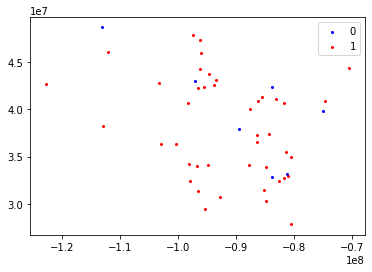

In [29]:
# Import the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scatter_x = np.array(list(map(lambda x: x[1:2][0], scd.data)))
scatter_y = np.array(list(map(lambda x: x[:1][0], scd.data)))
group = np.array(list(map(lambda x: x[2:3][0], scd.data)))
cdict = {0: "blue", 1: "red"}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 4)
ax.legend()
plt.show()
